In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import os
from tqdm import tqdm

print(os.listdir())
import matplotlib.pyplot as plt

['graph_example275.jpg', 'graph_example300.jpg', 'graph_example100.jpg', 'social_graph_indicator.txt', '.DS_Store', 'social_A.txt', 'social_graph_labels.txt', 'graph_example0.jpg', 'graph_example175.jpg', 'social_to_adjacency.ipynb', 'graph_example375.jpg', 'graph_example200.jpg', 'graph_example75.jpg', 'social_node_labels.txt', 'large_twitch_edges.csv', 'graph_example50.jpg', 'graph_example225.jpg', 'graph_example350.jpg', 'social.txt', 'graph_example150.jpg', 'artist_edges.csv', '.ipynb_checkpoints', 'graph_example125.jpg', 'graph_example325.jpg', 'sampling_test.ipynb', 'graph_example250.jpg', 'graph_example25.jpg']


In [2]:
social_data = pd.read_csv("artist_edges.csv")
print(social_data.shape)
np.savetxt(r'social_A.txt', social_data.values, fmt='%d', delimiter=",\t")

(819306, 2)


In [3]:
G = nx.Graph()
for i in tqdm(range(social_data.shape[0])):
    G.add_edge(social_data.iloc[i, 0], social_data.iloc[i,1])
G = nx.convert_node_labels_to_integers(G)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 819306/819306 [00:14<00:00, 58318.93it/s]


<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


(819306, 2)
50515
400
160000


  0%|                                                                                                                                                                               | 0/400 [00:00<?, ?it/s]

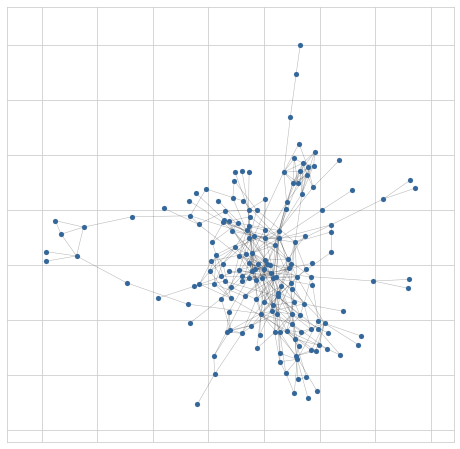

  5%|███████▉                                                                                                                                                              | 19/400 [00:00<00:06, 54.90it/s]

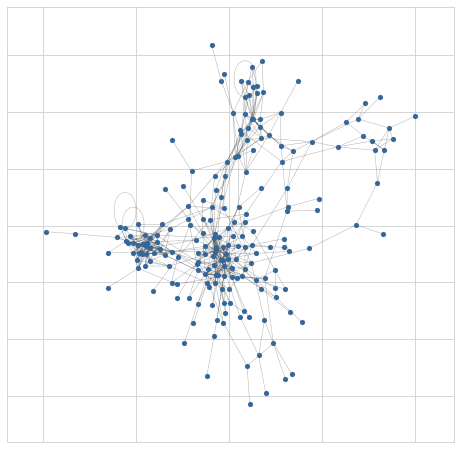

 11%|█████████████████▊                                                                                                                                                    | 43/400 [00:00<00:06, 55.03it/s]

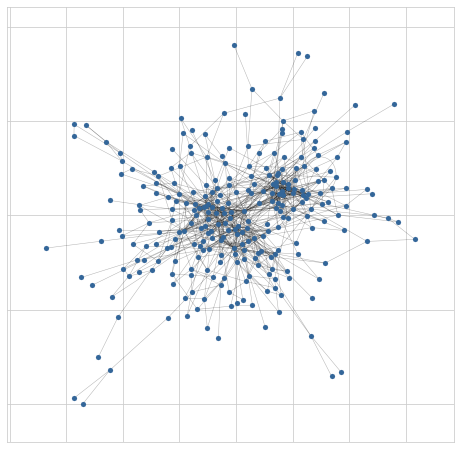

 19%|███████████████████████████████▏                                                                                                                                      | 75/400 [00:01<00:05, 59.42it/s]

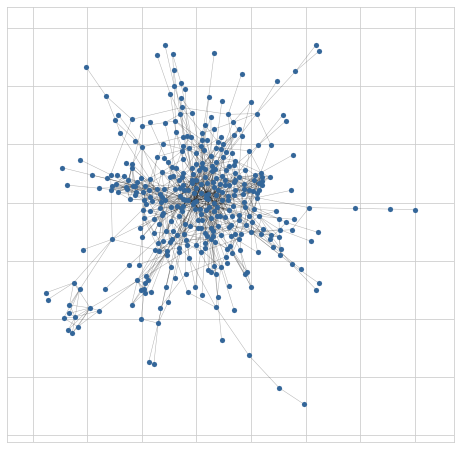

 25%|█████████████████████████████████████████▎                                                                                                                           | 100/400 [00:02<00:06, 48.63it/s]

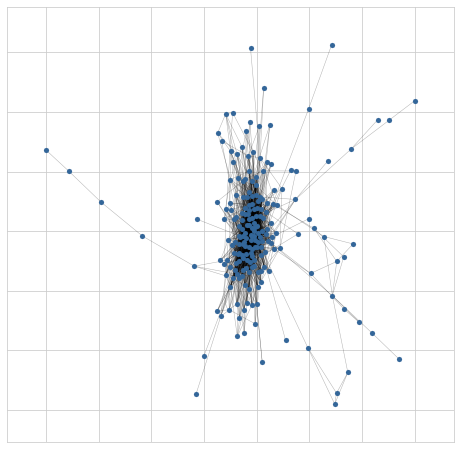

 31%|███████████████████████████████████████████████████▏                                                                                                                 | 124/400 [00:02<00:05, 54.01it/s]

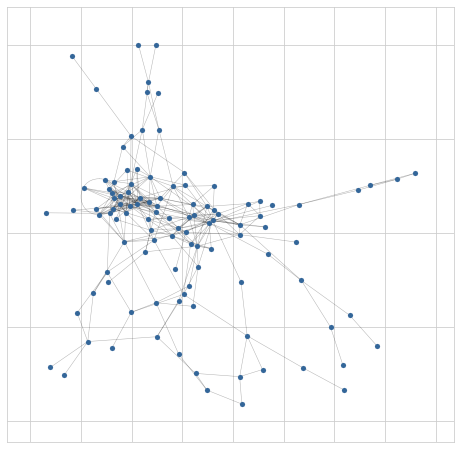

 37%|████████████████████████████████████████████████████████████▋                                                                                                        | 147/400 [00:03<00:04, 59.66it/s]

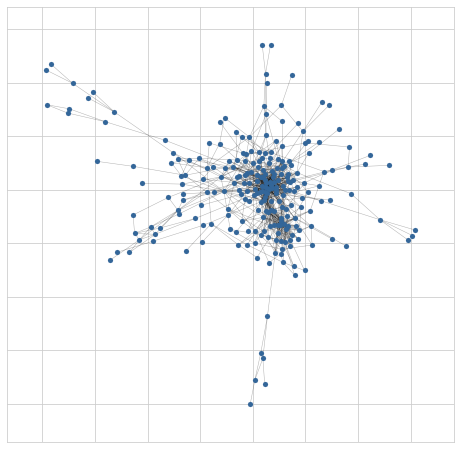

 43%|██████████████████████████████████████████████████████████████████████▌                                                                                              | 171/400 [00:03<00:03, 57.60it/s]

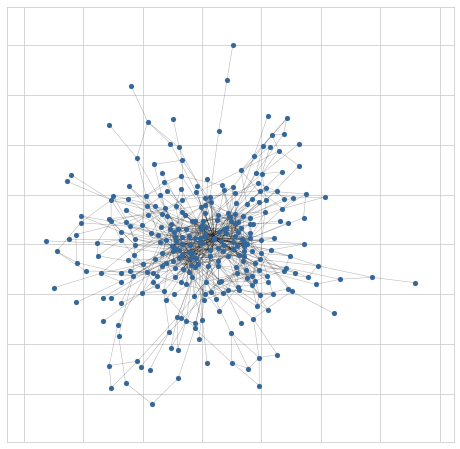

 48%|████████████████████████████████████████████████████████████████████████████████                                                                                     | 194/400 [00:04<00:03, 52.91it/s]

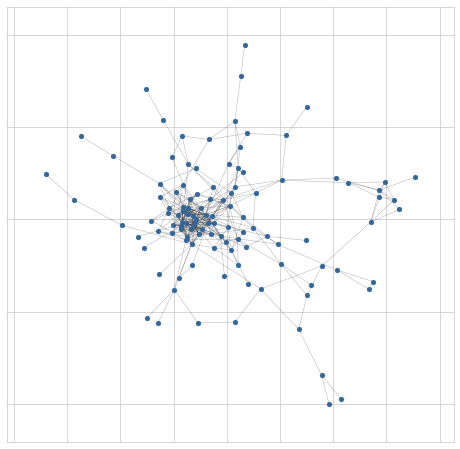

 55%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                           | 218/400 [00:04<00:03, 56.82it/s]

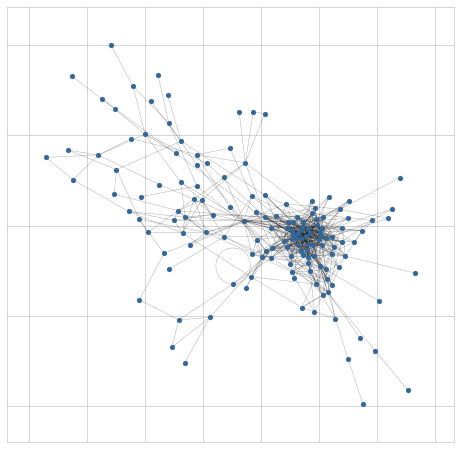

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 249/400 [00:05<00:02, 59.41it/s]

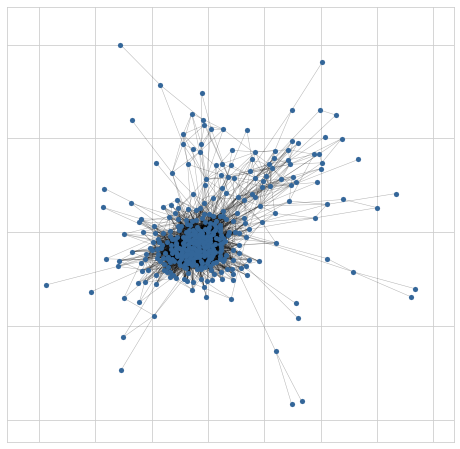

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 269/400 [00:05<00:03, 40.44it/s]

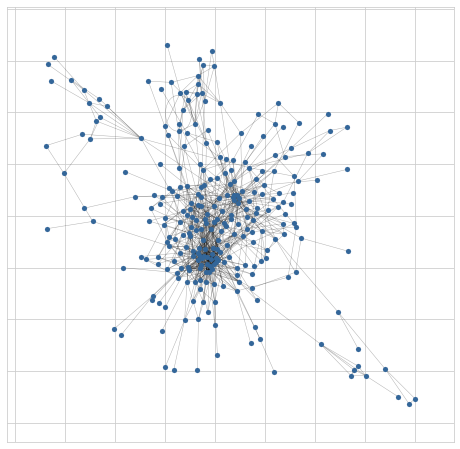

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 299/400 [00:06<00:01, 51.08it/s]

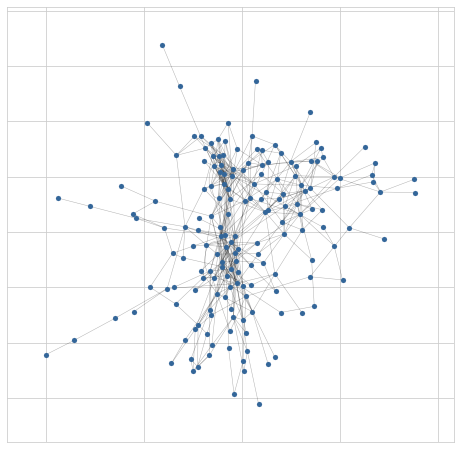

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 321/400 [00:06<00:01, 55.14it/s]

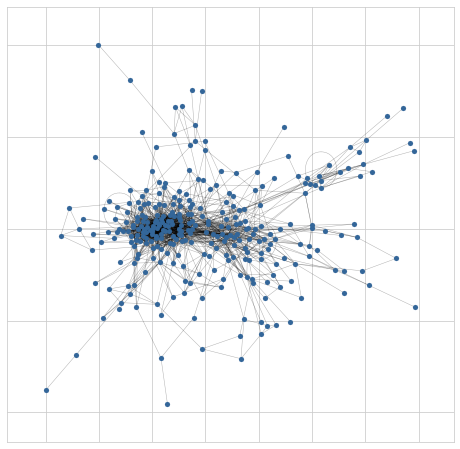

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 346/400 [00:07<00:01, 52.73it/s]

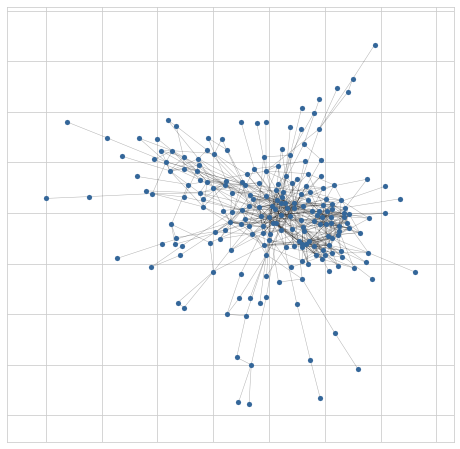

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 373/400 [00:08<00:00, 46.01it/s]

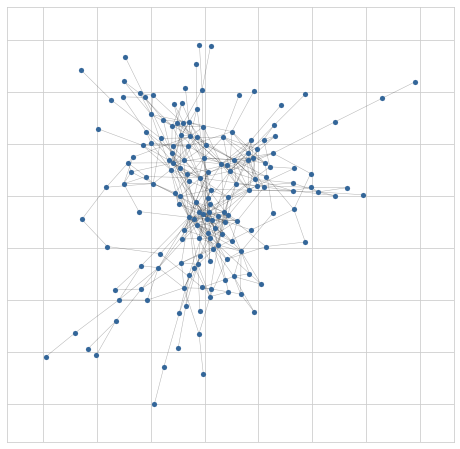

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 400/400 [00:08<00:00, 46.51it/s]


(452628, 2)
(160000,)
(160000,)
(160000,)


In [4]:
from littleballoffur import ForestFireSampler, MetropolisHastingsRandomWalkSampler, RandomWalkSampler, DiffusionSampler
print(social_data.shape)
n_nodes = np.unique(social_data.values).shape[0]
print(n_nodes)
n_graphs = 400

graph_ind_array = np.zeros(n_nodes)
n_per_graph = 400#int(n_nodes / n_graphs)

print(n_per_graph)

total_n = n_per_graph * n_graphs

print(total_n)
graph_ind_array = np.zeros(total_n)


#number_of_nodes = int(0.5*graph.number_of_nodes())


for i in tqdm(range(n_graphs)):
    
    offset_index = i * n_per_graph
    sampler = DiffusionSampler(number_of_nodes = np.random.randint(100, n_per_graph),
                               seed = np.random.randint(1, 1e6))
    new_graph = sampler.sample(G)
    
    # print(len(list(new_graph.nodes())))
    
    new_graph = nx.convert_node_labels_to_integers(new_graph, first_label=offset_index)
    
    graph_ind_array[offset_index:(i+1) * n_per_graph] = i+1
    
    
    if i ==0:
        graph_adj = np.array(new_graph.edges())
    else:
        graph_adj = np.append(graph_adj, np.array(new_graph.edges()), axis = 0)
    
    if i % 25 == 0:
        plt.figure(figsize = (8,8))
        
        pos = nx.spring_layout(
          new_graph, k=0.1, iterations=100)
        
        
        nx.draw_networkx_nodes(
          new_graph,
          pos,
          node_size=25,
          node_color='#336699',
          alpha=1,
          linewidths=0.2)#,
          # font_size=1.5)
        nx.draw_networkx_edges(new_graph, pos, alpha=0.3, width=0.5)

        plt.savefig(f"graph_example{i}.jpg")
        plt.show()

print(graph_adj.shape)
print(graph_ind_array.shape)

total_n = graph_ind_array.shape[0]
        
np.savetxt(r'social_A.txt', graph_adj, fmt='%d', delimiter=",\t")
np.savetxt(r'social_graph_indicator.txt',graph_ind_array, fmt="%d")

np.savetxt(r'social_node_labels.txt', np.arange(1, total_n+1), fmt = "%d")
print(np.arange(1, total_n+1).shape)

np.savetxt(r'social_graph_labels.txt', np.ones(total_n), fmt = "%d")
print(np.ones(total_n).shape)

In [5]:
# print(social_data.shape)
# n_nodes = np.unique(social_data.values).shape[0]
# print(n_nodes)
# n_graphs = 100

# graph_ind_array = np.zeros(n_nodes)
# n_per_graph = int(n_nodes / n_graphs)

# print(n_per_graph)

# G_ids = []

# for i in range(n_graphs):
    
#     G2 = nx.Graph()

#     for node in G.nodes():
        
#         neighbours = list(G.neighbors(node))


In [6]:


# # for i in range(n_graphs):
    
# #     graph_ind_array[i*n_per_graph : (i+1)*n_per_graph] = i+1
    
# #     if i == n_graphs - 1:
# #         graph_ind_array[(i+1)*n_per_graph:] = i+1

# np.savetxt(r'social_graph_indicator.txt',graph_ind_array, fmt="%d")
# print(graph_ind_array.shape)

In [7]:
# np.savetxt(r'social_node_labels.txt', np.arange(1, n_nodes+1), fmt = "%d")
# print(np.arange(1, n_nodes+1).shape)

In [8]:
# np.savetxt(r'social_graph_labels.txt', np.ones(n_nodes), fmt = "%d")
# print(np.ones(n_nodes).shape)

In [9]:
# adj = pd.read_csv("/Users/alexdavies/Documents/Year_1/Project/GRAN_social/data/DD/DD_A.txt", delimiter = ",|\n")
# adj.shape

In [10]:
# g_ind = pd.read_csv("/Users/alexdavies/Documents/Year_1/Project/GRAN_social/data/DD/DD_graph_indicator.txt", delimiter = ",|\n")
# g_ind.shape

In [11]:
# n_lab = pd.read_csv("/Users/alexdavies/Documents/Year_1/Project/GRAN_social/data/DD/DD_node_labels.txt", delimiter = ",|\n")
# n_lab.shape